In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import textwrap

import numpy as np
import pandas as pd
from scipy.stats import chi2

import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.kalman.turn import CoordinatedTurn
from tracking_v2.sensor import GeometricSensor
from tracking_v2.target import SingleTurnTarget, SinusTarget
from tracking.util import to_df

In [4]:
def moving_average(data, half_window_size):
    x = (np.arange(2*half_window_size + 1) - half_window_size - 1) / half_window_size * 2
    w = np.exp(-np.power(x, 2))
    w = w / np.sum(w)
    return np.convolve(data, w, 'same')

## Pick sigmas for process noise

### Heading noise as a function of Cartesian position noise

We consider a Coordinated Turn KF with 5-dimensional state representation: position and velocity in XY, and a turn rate. Process noise variance is the spatial XY dimensions depends on internal and external factors: target changing speed or turn rate, wind, and can be derived from assumptions about the target and the environment. However, process noise for the turn rate dimension must be derived from the known spatial process and measurement noise values.

Below, we present the turn rate noise in the function of target speed and total spatial noise.

In [7]:
def alpha_stdev(spatial_sigma, speed, N=1000):
    x0 = np.random.normal(0, spatial_sigma, (N, 2))
    x1 = np.hstack((np.random.normal(speed, spatial_sigma, (N, 1)), np.random.normal(0, spatial_sigma, (N, 1))))

    alpha = np.arctan2(x1[:,1] - x0[:,1], x1[:,0] - x0[:,0])
    return np.std(alpha)


data = []
for speed in range(1, 50, 5):
    for sigma in [.1, .2, .5, 1, 2, 5, 10]:
        data.append((speed, sigma, alpha_stdev(sigma, speed)))

data = to_df(np.array(data), columns=['speed', 'sigma', 'alpha_stdev'])

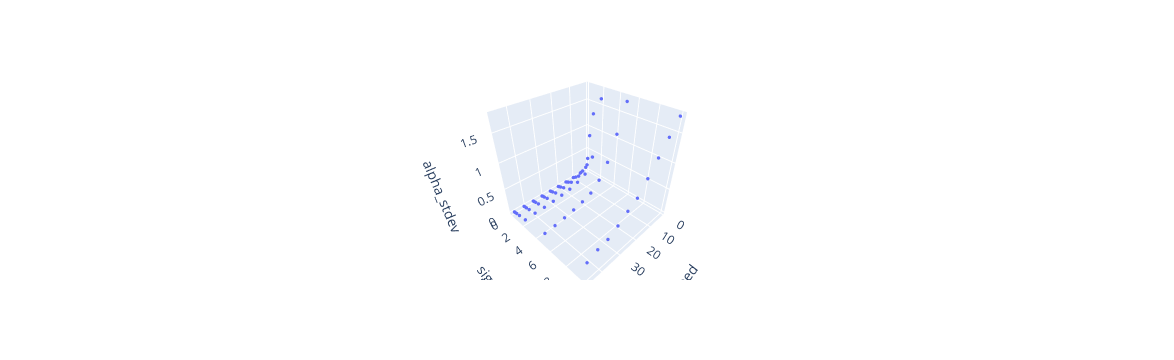

In [8]:
fig = ex.scatter_3d(data, x='speed', y='sigma', z='alpha_stdev')
fig.update_traces(marker_size=2)
fig

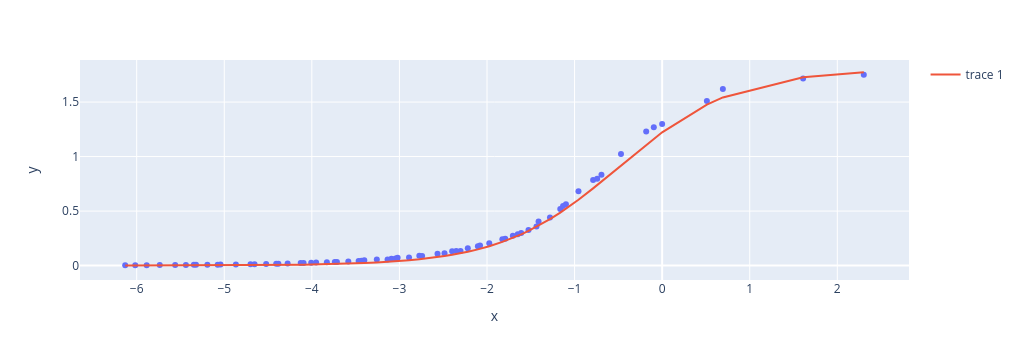

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = ex.scatter(x=-np.log(data['speed'] / data['sigma']), y=data['alpha_stdev'])

x = np.sort(-np.log(data['speed'] / data['sigma']))
fig.add_trace(go.Scatter(x=x, y=1.8*sigmoid(1.5*(x+.5))))
fig

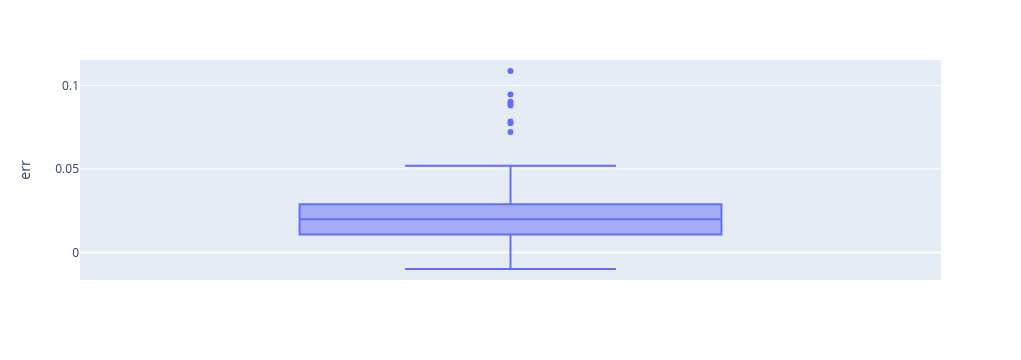

In [10]:
def derive_alpha_stdev(speed, sigma):
    return 1.8 * sigmoid(1.5 * (np.log(sigma / speed) + .5))

err = []
for speed in range(1, 50, 5):
    for sigma in [.1, .2, .5, 1, 2, 5, 10]:
        err.append((speed, sigma, alpha_stdev(sigma, speed) - derive_alpha_stdev(speed, sigma)))

err = to_df(np.array(err), columns=['speed', 'sigma', 'err'])
ex.box(err, y='err')

### Convergence of Kalman gain

In the context of moving objects, in a linear Kalman Filter with a constant sampling time $T$, the state transition matrix $F$ is also constant. If the measurement and process noise matrices $R$ and $Q$ are constant as well, the Kalman gain and the estimated covariance also converge to a predetermined matrices. Their values can be found by solving the following equation:

$$
P = P - K (F P F^T + R) K^T
$$

where

$$
K = (H F P F^T H^T + R)^{-1}
$$

or by iterating this equation until $P_k$ is sufficiently close to $P_{k+1}$.

In case of the Coordinated Turn model and constant sampling time $T$, the process noise matrix $Q$ is constant but the state transition matrix $F$ depends on the current state estimate.

In [11]:
sigma_spatial = 1
sigma_heading = 0.02

P = Q = np.diag([sigma_spatial, sigma_spatial, sigma_spatial, sigma_spatial, sigma_heading]) ** 2
T = 1

H = np.array([[1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0]])

R = np.array([[1, 0],
              [0, 1]])

ct = CoordinatedTurn(None, [None, None])
ct.x_hat = np.array([[0, 10, 0, 5, np.pi/3]]).T

P_k = P

In [12]:
for i in range(400):
    ct.x_hat = np.array([[0, 10, 0, 5, np.random.uniform(1e-6, np.pi/2)]]).T
    
    F = ct.f_x(T)
    P_fwd = F @ P_k @ F.T + Q
    S = H @ P_fwd @ H.T + R
    K = P_fwd @ H.T @ np.linalg.inv(S)
    P_k_1 = P_fwd - K @ S @ K.T

    #if np.mean(np.abs((P_k_1 - P_k)).reshape((-1))) < 0.0001:
    #    print(f"Stopped after {i} iterations")
    #    break

    P_k = P_k_1

In [13]:
P_k

array([[ 0.84138714,  0.48845941, -0.00639127, -0.01712938, -0.00614206],
       [ 0.48845941,  2.16456595, -0.06286203, -0.19584819, -0.02093112],
       [-0.00639127, -0.06286203,  0.82944099,  0.46610287,  0.00292139],
       [-0.01712938, -0.19584819,  0.46610287,  2.23597035,  0.02543071],
       [-0.00614206, -0.02093112,  0.00292139,  0.02543071,  0.00314659]])

In [14]:
F

array([[ 1.        ,  0.99971005,  0.        , -0.0208528 , -2.63792735],
       [ 0.        ,  0.9991302 ,  0.        , -0.04169956, -5.41264659],
       [ 0.        ,  0.0208528 ,  1.        ,  0.99971005,  4.92831805],
       [ 0.        ,  0.04169956,  0.        ,  0.9991302 ,  9.78280414],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

## Single turn

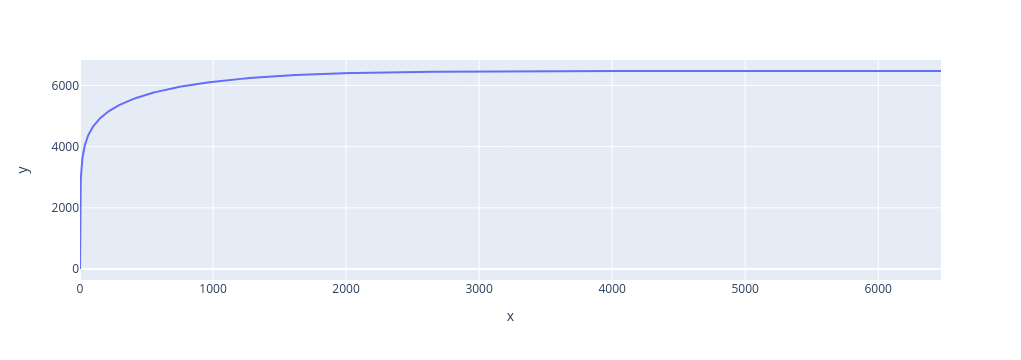

In [15]:
target = SingleTurnTarget(30, 1)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

ex.line(x=true_positions[:, 0], y=true_positions[:, 1])

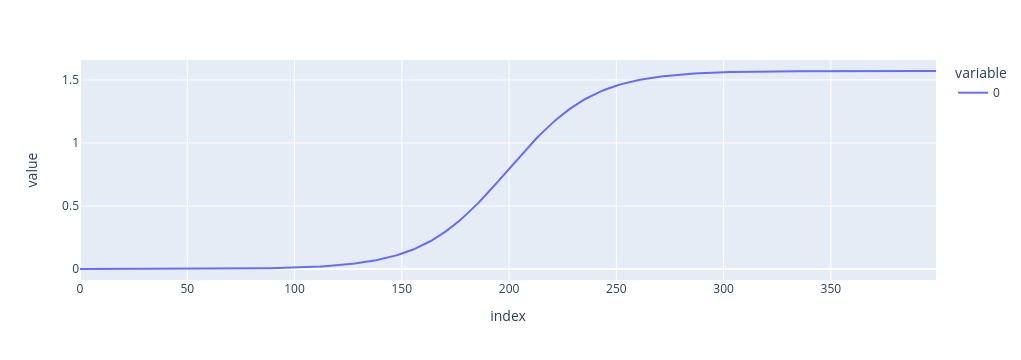

In [16]:
ex.line(target.heading())

In [17]:
derive_alpha_stdev(30, 1)

0.02289559440040238

In [18]:
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                      [1, .02289])
t = 0
ct.initialize(true_positions[t, :2], np.eye(2))

x = []
for _ in range(399):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])

    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    x.append(ct.x_hat)

x = np.array(x).squeeze()

In [19]:
df = to_df(np.hstack((
                np.arange(399).reshape((-1, 1)),
                true_positions[1:, :2],
                target.heading()[1:].reshape((-1, 1)),
                np.diff(target.heading()).reshape((-1, 1)),
                x)),
           columns=['t', 'x', 'y', 'heading', 'Omega', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega_hat'])

df['Omega_smooth'] = moving_average(df['Omega_hat'], 5)

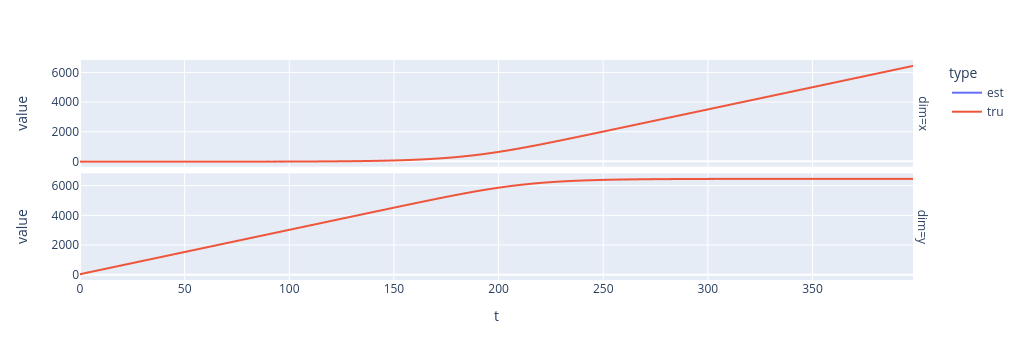

In [20]:
est = df[['t', 'x_hat', 'y_hat']].rename(columns=dict(x_hat='x', y_hat='y')).melt(['t'], ['x', 'y'], 'dim').assign(type='est')
tru = df[['t', 'x', 'y']].melt(['t'], ['x', 'y'], 'dim').assign(type='tru')
ex.line(pd.concat((est, tru)), x='t', y='value', color='type', facet_row='dim')

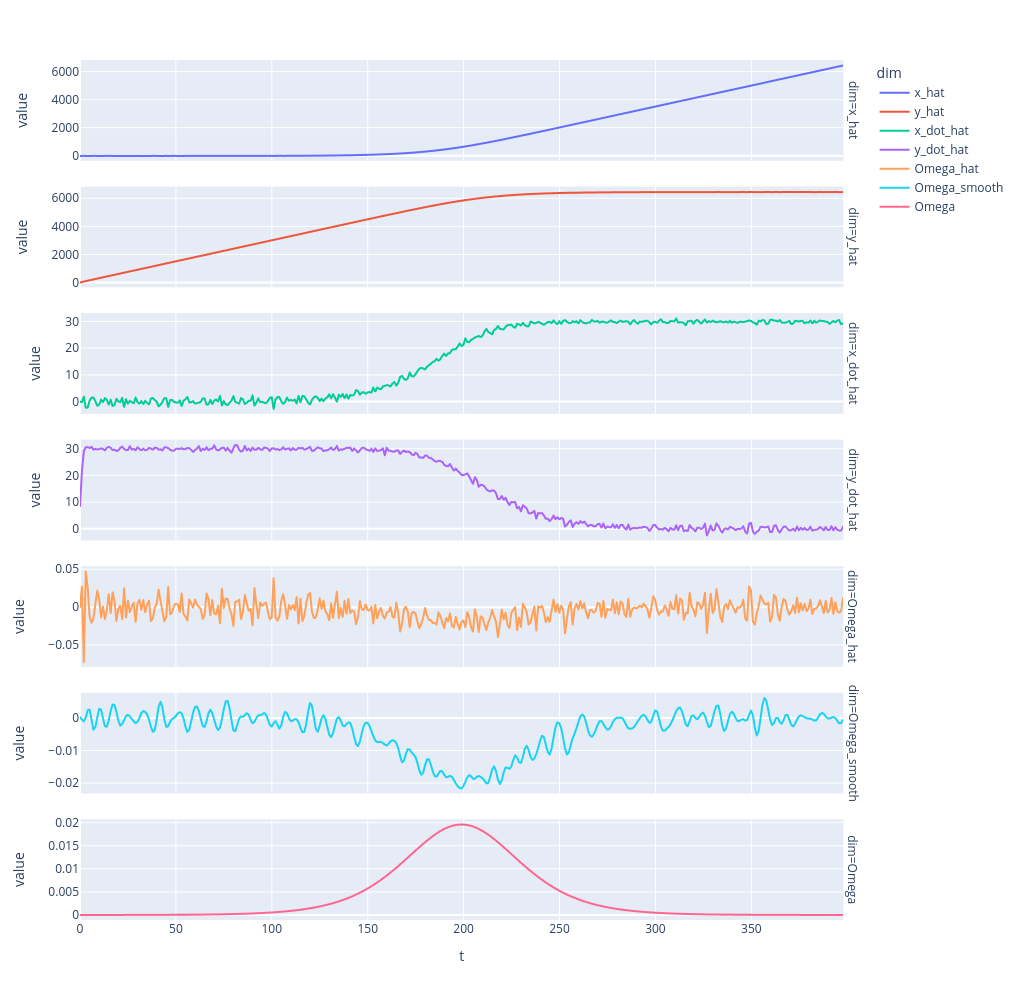

In [21]:
fig = ex.line(df.melt(['t'], ['x_hat', 'y_hat', 'x_dot_hat', 'y_dot_hat', 'Omega_hat', 'Omega_smooth', 'Omega'], 'dim'),
              x='t', y='value', color='dim', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig

## Multiple turns

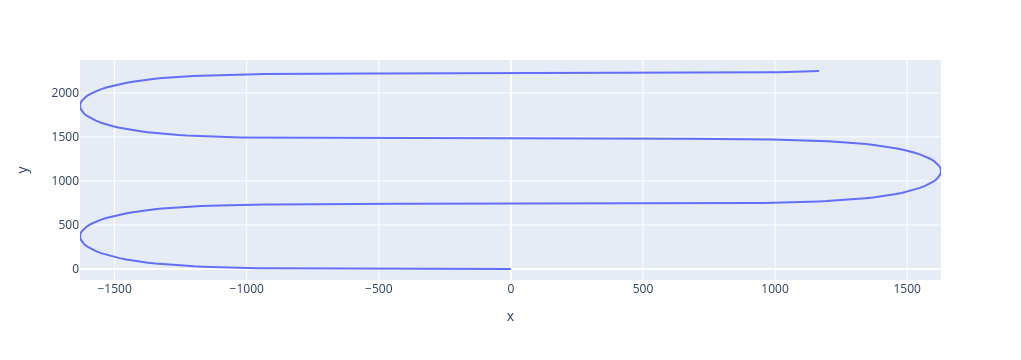

In [22]:
target = SinusTarget(30, 3)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

ex.line(x=true_positions[:, 0], y=true_positions[:, 1])

In [24]:
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                     [1, .02289])
t = 0
ct.initialize(true_positions[t, :2], np.eye(2))

In [25]:
x = []
for _ in range(399):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])

    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    x.append(ct.x_hat)

x = np.array(x).squeeze()

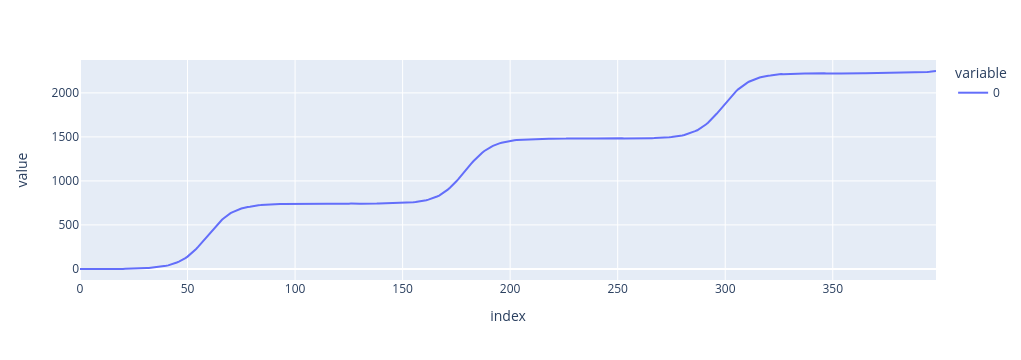

In [26]:
ex.line(x[:,2])

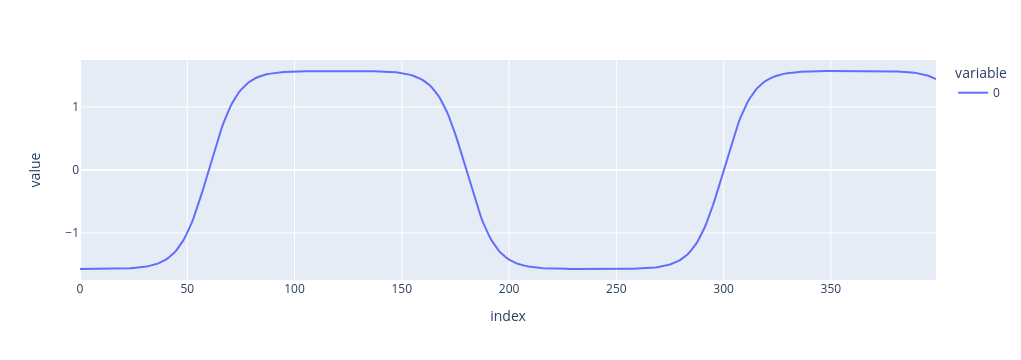

In [27]:
ex.line(target.heading())

In [28]:
df = to_df(np.hstack((np.arange(399).reshape((-1, 1)), true_positions[1:, :2], x)),
           columns=['t', 'x', 'y', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega'])
df

t            x            y        x_hat  x_dot_hat        y_hat  \
0      0.0   -29.999997     0.012453   -21.338762  -8.535505    -0.085465   
1      1.0   -59.999994     0.026921   -53.223607 -21.876751    -0.470196   
2      2.0   -89.999989     0.043731   -85.994266 -28.265192     1.069678   
3      3.0  -119.999983     0.063260  -119.873295 -31.793462    -0.382789   
4      4.0  -149.999974     0.085949  -152.179056 -32.061401    -0.235987   
..     ...          ...          ...          ...        ...          ...   
394  394.0  1046.738414  2236.585295  1046.367265  29.704472  2237.295205   
395  395.0  1076.648971  2238.898111  1077.228273  30.359504  2239.015720   
396  396.0  1106.529215  2241.573639  1107.950065  30.560388  2241.104647   
397  397.0  1136.369081  2244.666490  1135.666976  28.946979  2243.797169   
398  398.0  1166.155278  2248.238664  1165.232033  29.223004  2248.551442   

     y_dot_hat     Omega  
0    -0.034186  0.000000  
1    -0.542514  0.050521  
2     2.525968 -0.109043  
3    -0.748900  0.020161  
4    -0.210063  0.004438  
..         ...       ...  
394   2.686751  0.014362  
395   2.116147  0.002993  
396   2.138859  0.002069  
397   2.695132  0.008682  
398   4.527466  0.025375  

[399 rows x 8 columns]

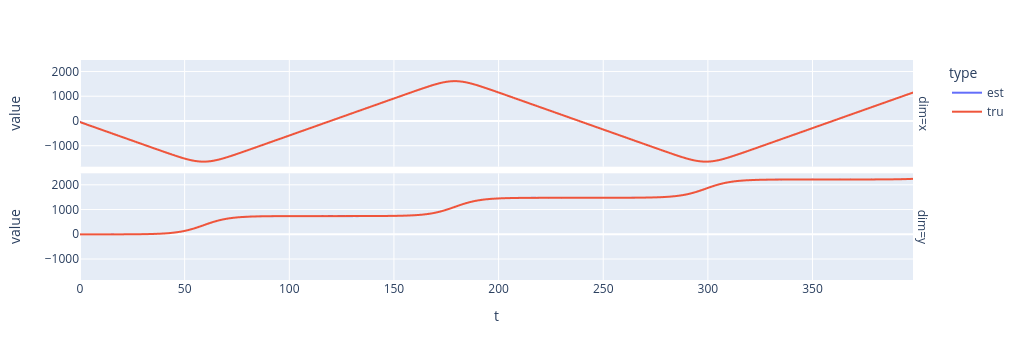

In [29]:
est = df[['t', 'x_hat', 'y_hat']].rename(columns=dict(x_hat='x', y_hat='y')).melt(['t'], ['x', 'y'], 'dim').assign(type='est')
tru = df[['t', 'x', 'y']].melt(['t'], ['x', 'y'], 'dim').assign(type='tru')
ex.line(pd.concat((est, tru)), x='t', y='value', color='type', facet_row='dim')

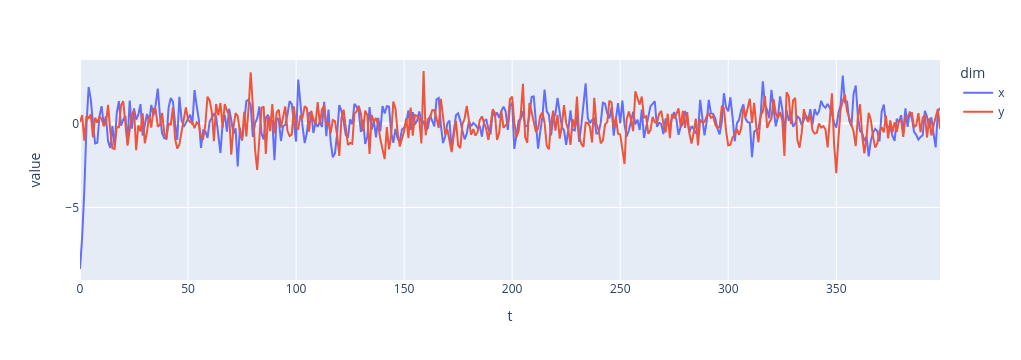

In [30]:
err = to_df(np.vstack((np.arange(399), true_positions[1:, 0]-x[:,0], true_positions[1:, 1]-x[:,2])).T,
           columns=['t', 'x', 'y'])
ex.line(err.melt(['t'], ['x', 'y'], 'dim'), x='t', y='value', color='dim')

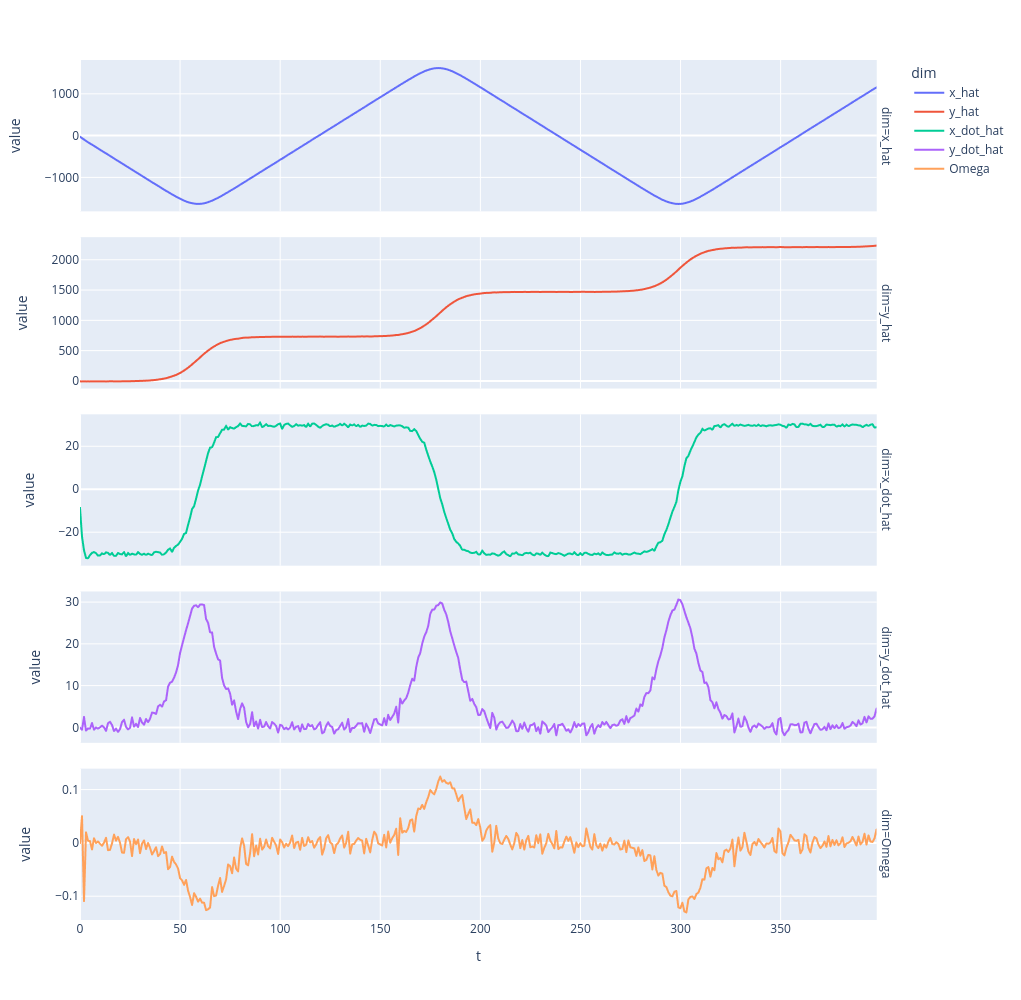

In [31]:
fig = ex.line(df.melt(['t'], ['x_hat', 'y_hat', 'x_dot_hat', 'y_dot_hat', 'Omega'], 'dim'), x='t', y='value', color='dim',
              facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig

In [32]:
df = to_df(np.hstack((np.arange(399).reshape((-1, 1)), true_positions[1:, :2], target.heading()[1:].reshape((-1, 1)), x)),
           columns=['t', 'x', 'y', 'Omega', 'x_hat', 'x_dot_hat', 'y_hat', 'y_dot_hat', 'Omega_hat'])

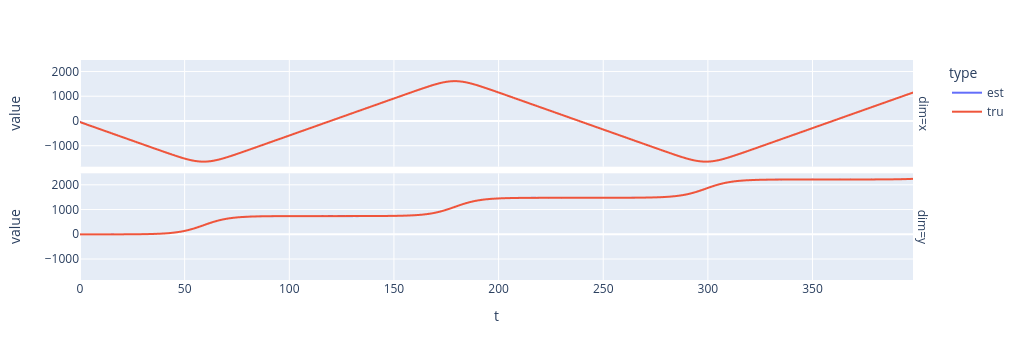

In [33]:
est = df[['t', 'x_hat', 'y_hat']].rename(columns=dict(x_hat='x', y_hat='y')).melt(['t'], ['x', 'y'], 'dim').assign(type='est')
tru = df[['t', 'x', 'y']].melt(['t'], ['x', 'y'], 'dim').assign(type='tru')
ex.line(pd.concat((est, tru)), x='t', y='value', color='type', facet_row='dim')

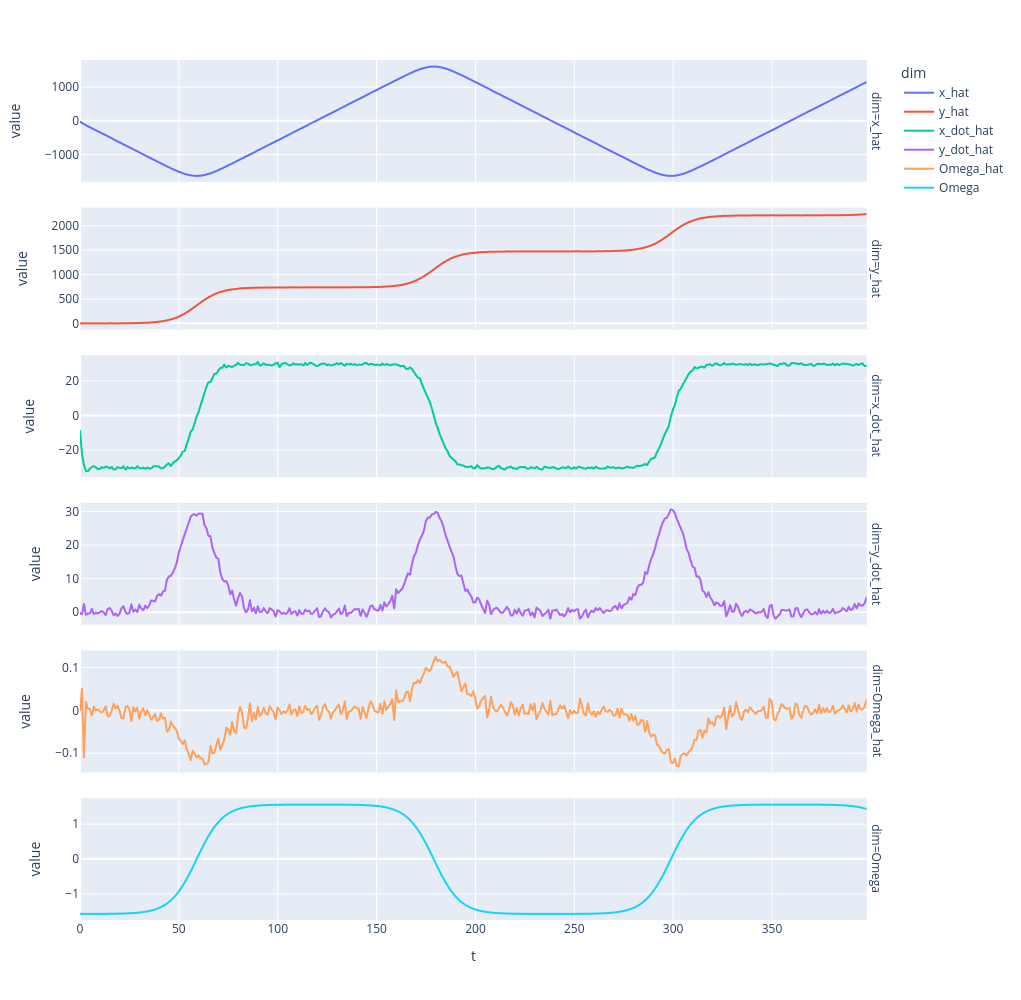

In [34]:
fig = ex.line(df.melt(['t'], ['x_hat', 'y_hat', 'x_dot_hat', 'y_dot_hat', 'Omega_hat', 'Omega'], 'dim'),
              x='t', y='value', color='dim', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig

In [35]:
x0 = np.random.normal(0, 1, (100, 2))
x1 = np.hstack((np.random.normal(30, 1, (100, 1)), np.random.normal(0, 1, (100, 1))))

alpha = np.arctan2(x1[:,1] - x0[:,1], x1[:,0] - x0[:,0])

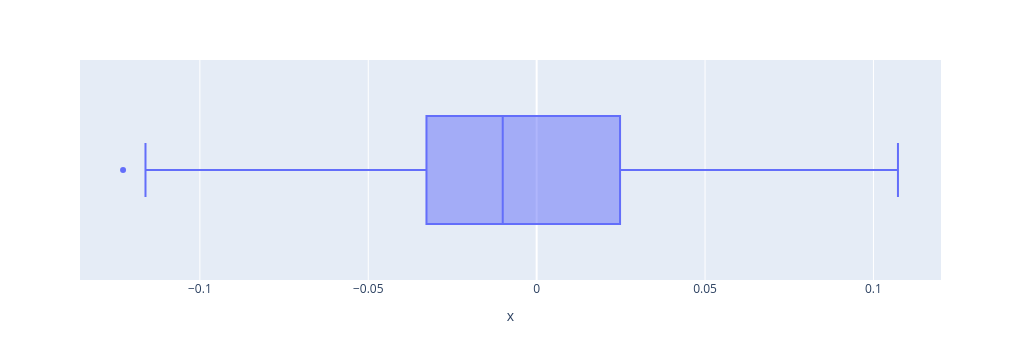

In [36]:
ex.box(x=alpha)

In [37]:
np.std(alpha)

0.04204357544703595

## Consequences of variance mismatch

Unlike in the linear Kalman Filter, where choosing the wrong value for the variance of the process or measurement noise, choosing the wrong variance for the turn rate in this implementation of the Extended Kalman Filter might lead to its unstable behavior.

In [59]:
target = SingleTurnTarget(30, 1)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

omega_sigma = np.sqrt(0.5) # effective variance will be 0.5

sensor = GeometricSensor(seed=0)
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                      [1, omega_sigma])
t = 0
ct.initialize(np.concatenate((true_positions[t, :2], [0, 0, 0])),
              np.diag([1, 1, 1, 1, omega_sigma]))

trace = []
for _ in range(100):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])
    noise = m.z[0, :2] - true_positions[t, :2]

    x_k = np.copy(ct.x_hat)
    
    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    trace.append(np.hstack(([t], noise.flat, target.heading()[t], ct.K[4,:].flat, ct.innovation.flat, (ct.x_hat-x_k).flat)))

trace = np.array(trace)
trace = to_df(trace, columns=['t', 'x_noise', 'y_noise', 'omega', 'K_omega_x', 'K_omega_y', 'x_innov', 'y_innov',
                              'x_delta', 'y_delta', 'vx_delta', 'vy_delta', 'o_delta'],)

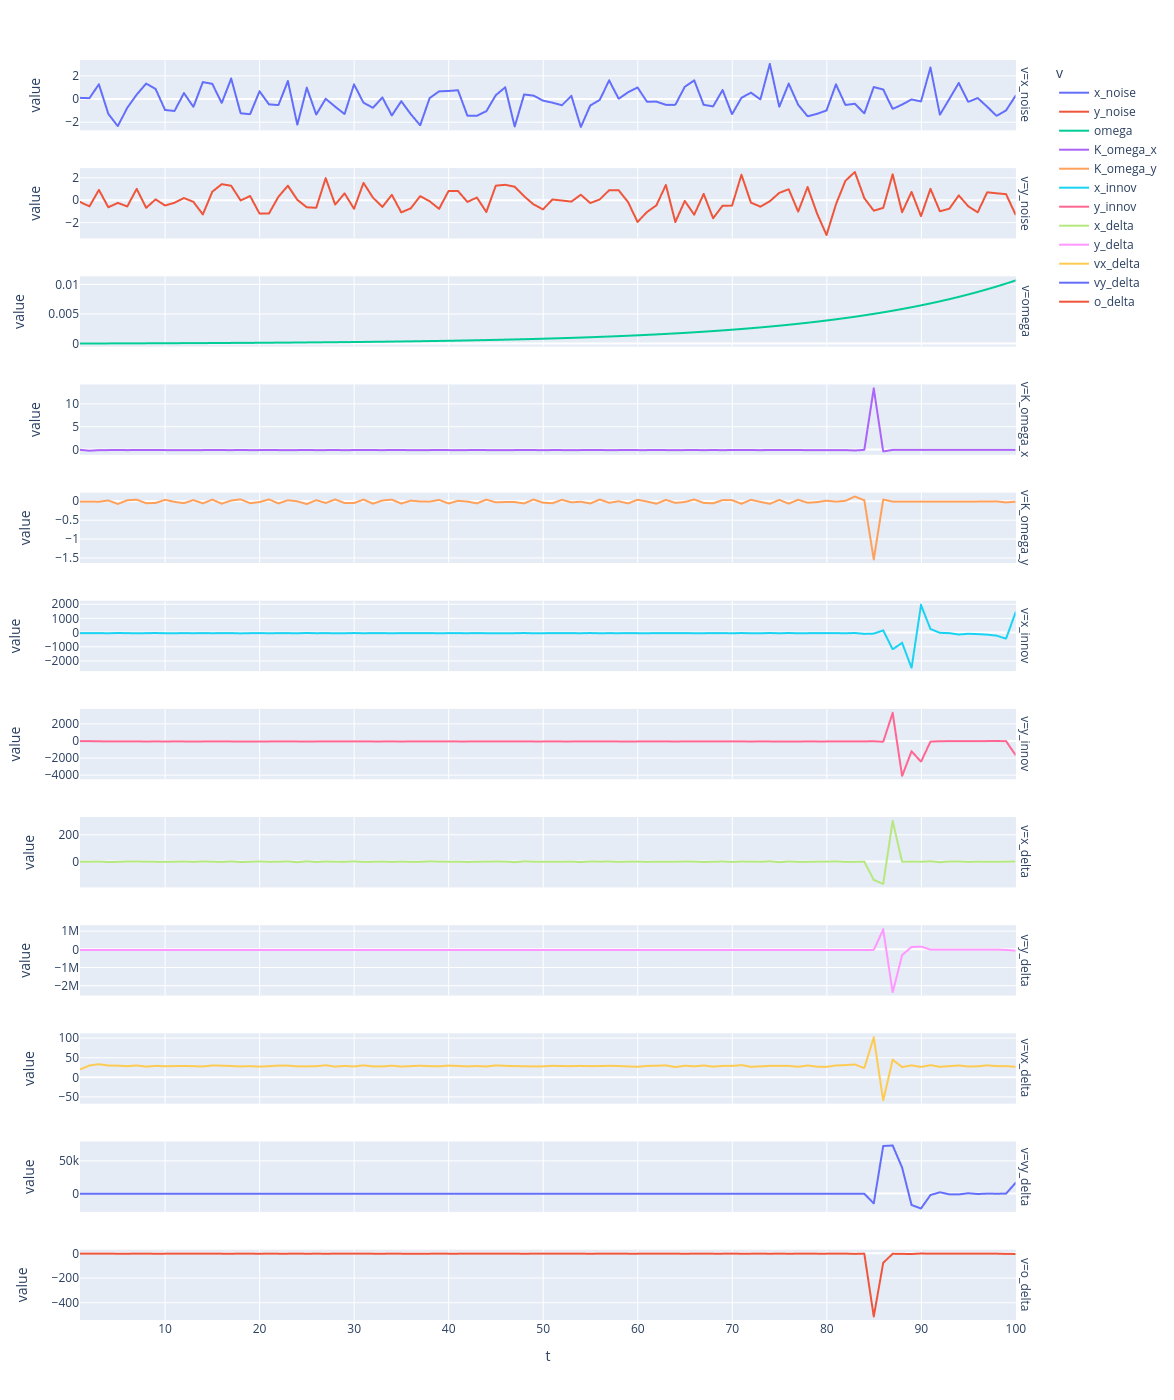

In [61]:
fig = ex.line(trace.melt(['t'], ['x_noise', 'y_noise', 'omega', 'K_omega_x', 'K_omega_y', 'x_innov', 'y_innov',
                                 'x_delta', 'y_delta', 'vx_delta', 'vy_delta', 'o_delta'], 'v'),
              x='t', y='value', color='v', facet_row='v')
fig.update_yaxes(matches=None)
fig.update_layout(height=1400)
fig

### Step-by-step

At $t=85$, the filter produces. What happens at $t=83$?

In [138]:
target = SingleTurnTarget(30, 1)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

omega_sigma = np.sqrt(0.5) # effective variance will be 0.5

sensor = GeometricSensor(seed=0)
ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0]],
                      [1, omega_sigma])
t = 0
ct.initialize(np.concatenate((true_positions[t, :2], [0, 0, 0])),
              np.diag([1, 1, 1, 1, omega_sigma]))

trace_size = 6
trace = []

for _ in range(80):
    t += 1
    m = sensor.generate_measurement(t, true_positions[t, :3])

    x_k = np.copy(ct.x_hat)
    
    ct.predict(1)
    ct.update(m.z[:, :2], m.R[:2, :2])

    trace.append((true_positions[t, :2], x_k.flatten(), m.z.flatten(), np.copy(ct.x_hat).flatten(), target.heading()[t]))
    while len(trace) > trace_size:
        trace.pop(0)

In [139]:
def one_step():
    global t
    truth, x_k, z, x_k_1, heading = map(np.array, zip(*trace))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=truth[:-1,0], y=truth[:-1,1], name='truth', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=x_k[1:,0], y=x_k[1:,2], name='x_hat', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=z[:-1,0], y=z[:-1,1], name='z', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=[z[-1,0]], y=[z[-1,1]], name='next z'))
    fig.add_trace(go.Scatter(x=[x_k_1[-1,0]], y=[x_k_1[-1,2]], name='next x_hat'))
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(t-len(trace)+2, t+1), y=np.diff(heading)))
    fig.add_trace(go.Scatter(x=np.arange(t-len(trace)+2, t+1), y=x_k_1[1:,4]))
    fig.show()
    
    with np.printoptions(precision=4, suppress=True):
        t += 1
        m = sensor.generate_measurement(t, true_positions[t, :3])
        
        print("t:     ", t)
        print("pos:   ", true_positions[t, :2])
        print("vel:   ", true_positions[t, 3:5])
        print("head:  ", target.heading()[t])
        
        print()
        print("meas:  ", m.z)
        print("noise: ", m.z - np.concatenate((true_positions[t, :2], [target.heading()[t]])))

        x_k = np.copy(ct.x_hat)

        print("\nf_x: ", textwrap.indent(str(ct.f_x(1)), "        ")[6:])
        
        ct.predict(1)

        print("\nP_hat: ", textwrap.indent(str(ct.P_hat), "        ")[8:])
        print("\nP_hat @ H.T:\n", textwrap.indent(str(ct.P_hat @ ct.H.T), "        ")[1:])

        ct.update(m.z[:, :2], m.R[:2, :2])

        print("\nS: ", textwrap.indent(str(ct.S), "        ")[4:])
        print("\nS^1: ", textwrap.indent(str(np.linalg.inv(ct.S)), "        ")[6:])

        print()
        print("K:", end='')
        print(textwrap.indent(str(ct.K), "        ")[2:])
        print("inn:   ", ct.innovation.T)

        print("delta: ", (ct.x_hat-x_k).T)

    trace.append((true_positions[t, :2], x_k.flatten(), m.z.flatten(), np.copy(ct.x_hat).flatten(), target.heading()[t]))
    while len(trace) > trace_size:
        trace.pop(0)

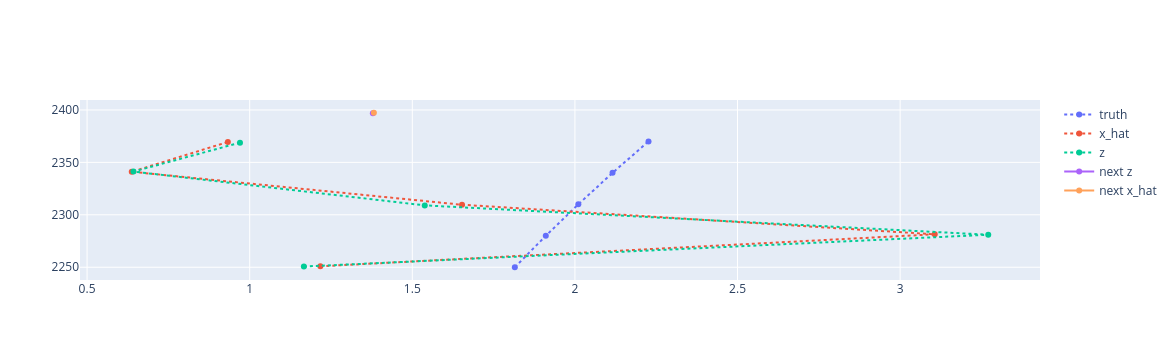

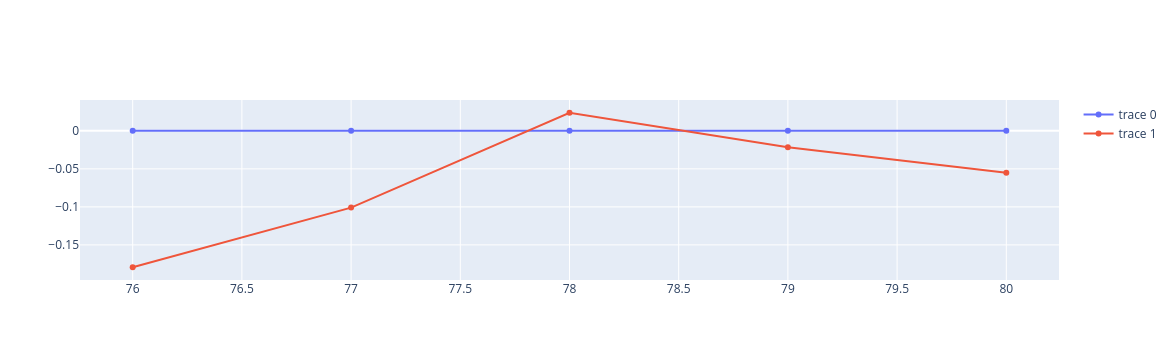

t:      81
pos:    [   2.4647 2429.9974]
vel:    [ 0.1256 29.9997]
head:   0.004185682359517705

meas:   [[   3.7616 2429.6517    0.8546]]
noise:  [[ 1.2969 -0.3457  0.8504]]

f_x:    [[  1.       0.9995   0.       0.0275 -14.2609]
         [  0.       0.9985   0.       0.0551 -28.4762]
         [  0.      -0.0275   1.       0.9995   1.1786]
         [  0.      -0.0551   0.       0.9985   2.8807]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[171.237  299.055  -15.3174 -30.951   -9.2756]
         [305.1515 550.8827 -27.3249 -57.0653 -17.4493]
         [-16.4014 -28.3493   5.5572   5.2729   0.856 ]
         [-32.2339 -57.7359   5.1873   8.8395   1.8186]
         [ -9.3949 -17.4846   0.8326   1.8096   1.0729]]

P_hat @ H.T:
        [[171.237  -15.3174]
         [305.1515 -27.3249]
         [-16.4014   5.5572]
         [-32.2339   5.1873]
         [ -9.3949   0.8326]]

S:      [[172.237  -15.3174]
         [-16.4014   6.5572]]

S^1:    [[0.0075 0.0174]
         [0.018

In [140]:
one_step()

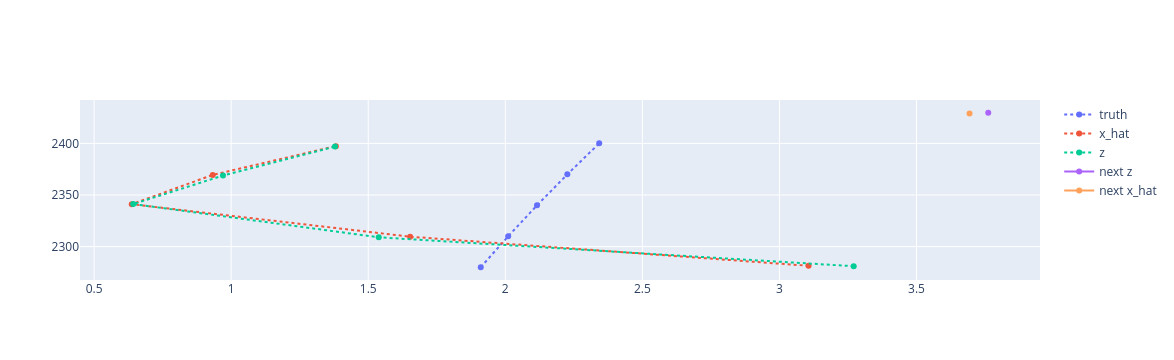

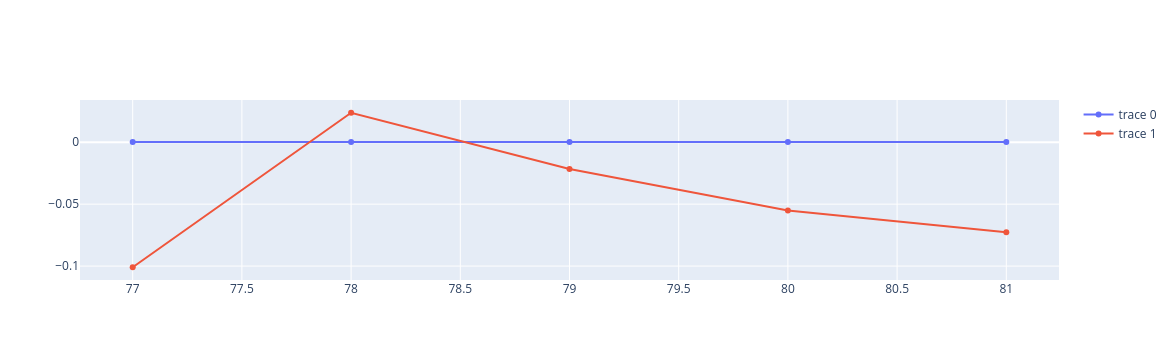

t:      82
pos:    [   2.5932 2459.9971]
vel:    [ 0.132  29.9997]
head:   0.004399685791574395

meas:   [[   2.1042 2461.7578    0.1992]]
noise:  [[-0.489   1.7607  0.1948]]

f_x:    [[  1.       0.9991   0.       0.0364 -14.9824]
         [  0.       0.9974   0.       0.0727 -29.8464]
         [  0.      -0.0364   1.       0.9991   2.3513]
         [  0.      -0.0727   0.       0.9974   5.4288]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[ 159.493   291.      -22.6391  -52.1447   -9.1311]
         [ 301.2084  559.043   -44.7367 -100.6737  -17.5224]
         [ -22.8849  -42.8134    7.3964   10.031     1.372 ]
         [ -53.7363 -100.0587   10.2941   20.9107    3.162 ]
         [  -9.29    -17.5596    1.4156    3.1828    1.0604]]

P_hat @ H.T:
        [[159.493  -22.6391]
         [301.2084 -44.7367]
         [-22.8849   7.3964]
         [-53.7363  10.2941]
         [ -9.29     1.4156]]

S:      [[160.493  -22.6391]
         [-22.8849   8.3964]]

S^1:    [[0.010

In [141]:
one_step()

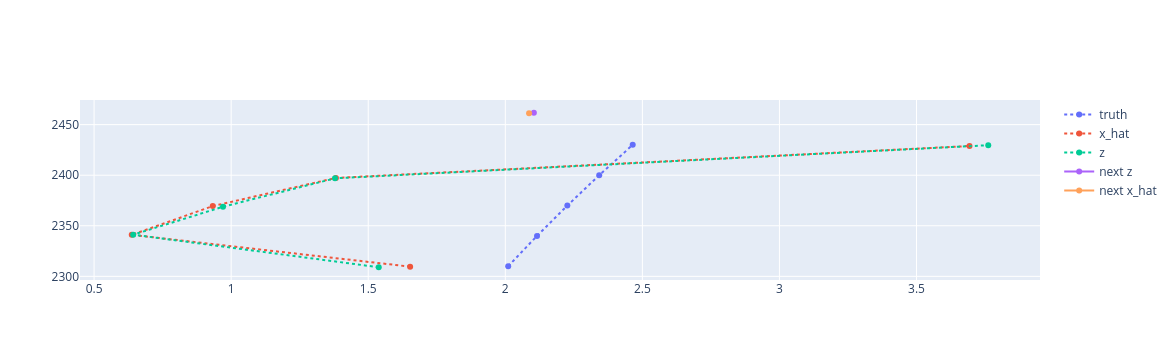

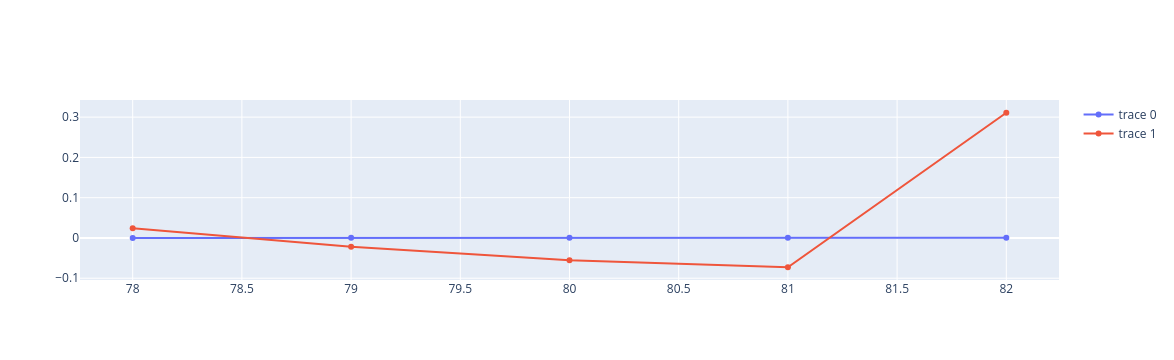

t:      83
pos:    [   2.7282 2489.9968]
vel:    [ 0.1387 29.9997]
head:   0.004624598382984592

meas:   [[   2.3462 2492.5492   -0.3245]]
noise:  [[-0.382   2.5524 -0.3291]]

f_x:    [[  1.       0.984    0.      -0.1542 -15.37  ]
         [  0.       0.9521   0.      -0.3059 -29.2934]
         [  0.       0.1542   1.       0.984   -6.5772]
         [  0.       0.3059   0.       0.9521 -16.3066]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[112.231  219.0096  51.1245 126.9882  -7.9556]
         [233.9582 444.7685  98.7892 247.9622 -15.3038]
         [ 56.7186 104.3369  26.6721  59.2692  -3.4721]
         [132.8532 249.8813  57.6107 141.434   -8.51  ]
         [ -8.1474 -15.3443  -3.3967  -8.495    1.0208]]

P_hat @ H.T:
        [[112.231   51.1245]
         [233.9582  98.7892]
         [ 56.7186  26.6721]
         [132.8532  57.6107]
         [ -8.1474  -3.3967]]

S:      [[113.231   51.1245]
         [ 56.7186  27.6721]]

S^1:    [[ 0.1184 -0.2188]
         [-0.

In [142]:
one_step()

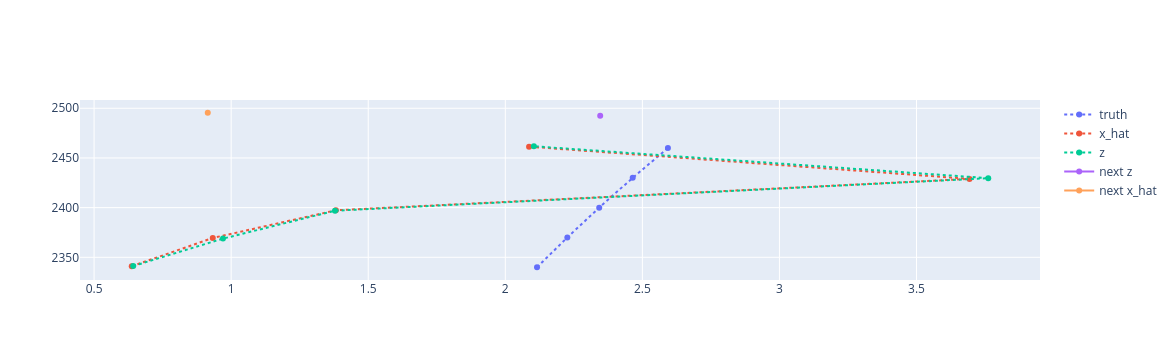

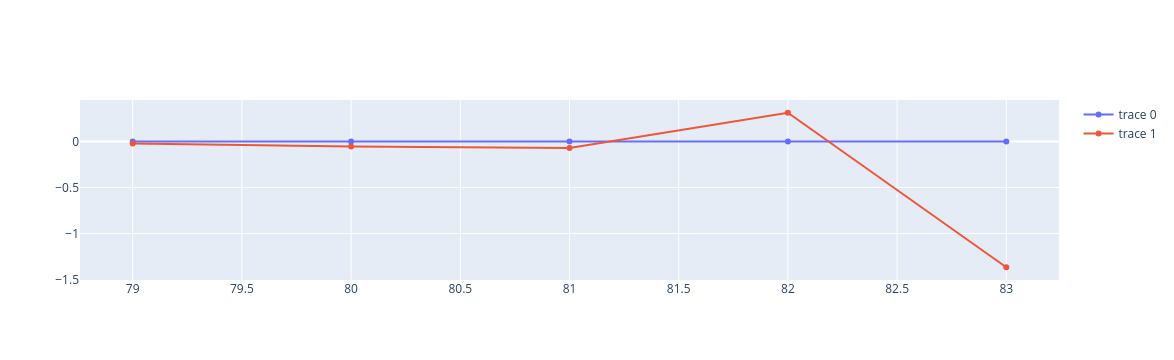

t:      84
pos:    [   2.8701 2519.9965]
vel:    [ 0.1458 29.9996]
head:   0.004860972859283108

meas:   [[   1.6488 2520.1984   -0.0388]]
noise:  [[-1.2212  0.2019 -0.0437]]

f_x:    [[ 1.      0.7168  0.      0.5832 -3.935 ]
         [ 0.      0.2034  0.      0.9791 17.3883]
         [ 0.     -0.5832  1.      0.7168 26.9943]
         [ 0.     -0.9791  0.      0.2034 54.7834]
         [ 0.      0.      0.      0.      1.    ]]

P_hat:  [[-149.4758  -30.8203  125.5848  333.5848    3.6967]
         [ -41.6264  153.7655  245.4655  499.2479    8.976 ]
         [  59.7252  232.6059  239.212   421.0428    9.3219]
         [ 215.9246  463.6966  367.9387  575.6313   15.1862]
         [   2.2112    8.5081    8.6727   15.3795    0.8411]]

P_hat @ H.T:
        [[-149.4758  125.5848]
         [ -41.6264  245.4655]
         [  59.7252  239.212 ]
         [ 215.9246  367.9387]
         [   2.2112    8.6727]]

S:      [[-148.4758  125.5848]
         [  59.7252  240.212 ]]

S^1:    [[-0.0056  0.0029]

In [143]:
one_step()

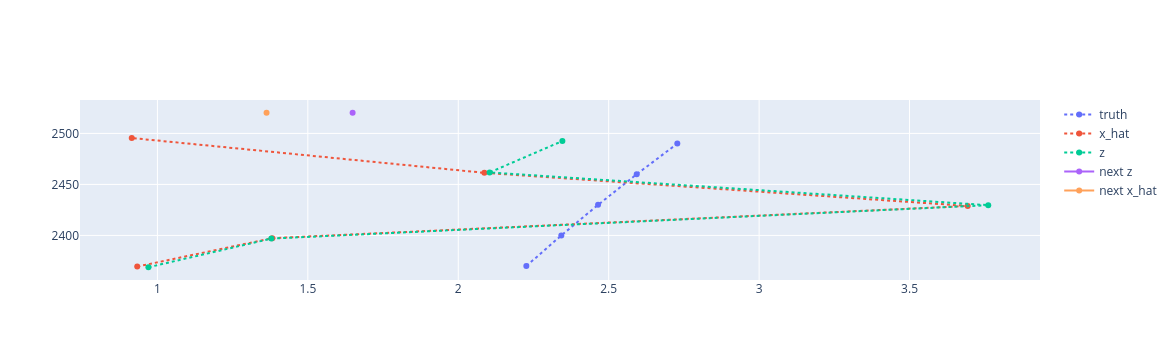

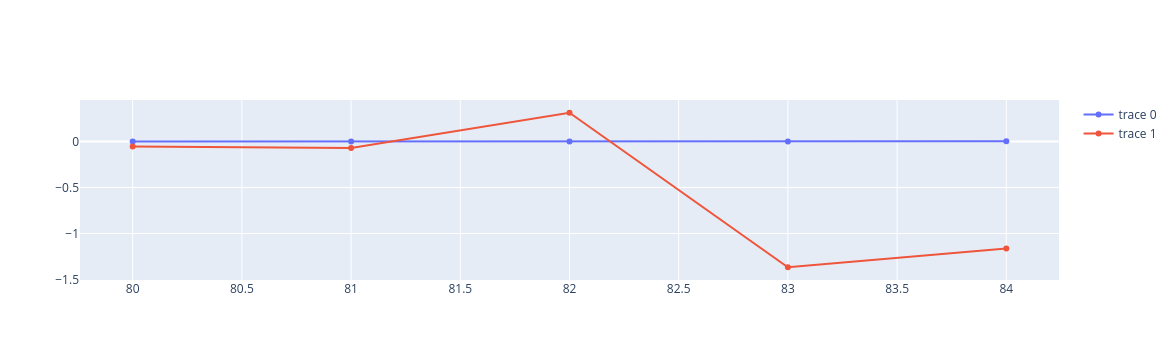

t:      85
pos:    [   3.0192 2549.9961]
vel:    [ 0.1533 29.9996]
head:   0.005109389595662179

meas:   [[   4.0855 2549.0745    0.8047]]
noise:  [[ 1.0663 -0.9216  0.7996]]

f_x:    [[ 1.      0.7898  0.      0.5184  1.3711]
         [ 0.      0.3979  0.      0.9174 17.7864]
         [ 0.     -0.5184  1.      0.7898 19.4115]
         [ 0.     -0.9174  0.      0.3979 36.287 ]
         [ 0.      0.      0.      0.      1.    ]]

P_hat:  [[ 12.6315  27.7145  25.9914  32.6322   0.8582]
         [102.3799 267.2278 203.7012 341.0381  11.1537]
         [118.2245 296.2917 220.0037 369.8379  12.3756]
         [ 90.3    400.4502 371.3408 670.7528  19.8346]
         [  1.7564  10.2111  10.1473  18.4327   1.0272]]

P_hat @ H.T:
        [[ 12.6315  25.9914]
         [102.3799 203.7012]
         [118.2245 220.0037]
         [ 90.3    371.3408]
         [  1.7564  10.1473]]

S:      [[ 13.6315  25.9914]
         [118.2245 221.0037]]

S^1:    [[-3.6702  0.4316]
         [ 1.9634 -0.2264]]

K:      [

In [144]:
one_step()

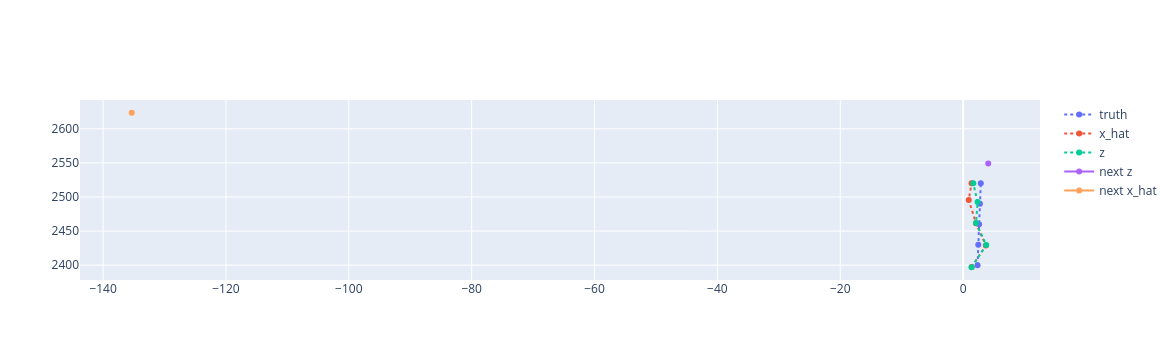

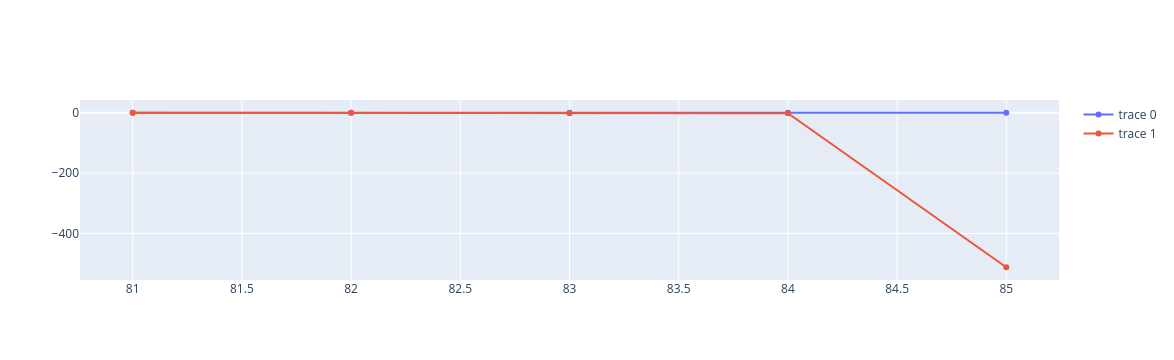

t:      86
pos:    [   3.176  2579.9957]
vel:    [ 0.1611 29.9996]
head:   0.005370457962895866

meas:   [[   4.0287 2579.328     0.1632]]
noise:  [[ 0.8527 -0.6677  0.1579]]

f_x:    [[     1.          0.0002      0.          0.0039      0.9799]
         [     0.         -0.9956      0.          0.0939 -15097.3042]
         [     0.         -0.0039      1.          0.0002    -29.4866]
         [     0.         -0.0939      0.         -0.9956   -560.6497]
         [     0.          0.          0.          0.          1.    ]]

P_hat:  [[-1.8956e+02  2.0967e+06  4.1159e+03  8.1985e+04 -1.3889e+02]
         [ 1.4964e+05 -1.6164e+09 -3.1749e+06 -6.3424e+07  1.0707e+05]
         [-1.4047e+03  1.5566e+07  3.0553e+04  6.0816e+05 -1.0311e+03]
         [ 6.4948e+03 -7.0370e+07 -1.3821e+05 -2.7597e+06  4.6614e+03]
         [-9.8217e+00  1.0608e+05  2.0835e+02  4.1622e+03 -6.5266e+00]]

P_hat @ H.T:
        [[    -189.5638     4115.8966]
         [  149638.0607 -3174938.639 ]
         [   -1404.

In [145]:
one_step()